In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import datetime as dt

from statsmodels.tsa.api import VARMAX
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('full_corporate.csv', index_col=0)
# data = data.set_index('datetime')
data.index = pd.DatetimeIndex(data.index)
data = data[data.index.dayofweek < 5]
data.shape

(57773, 15)

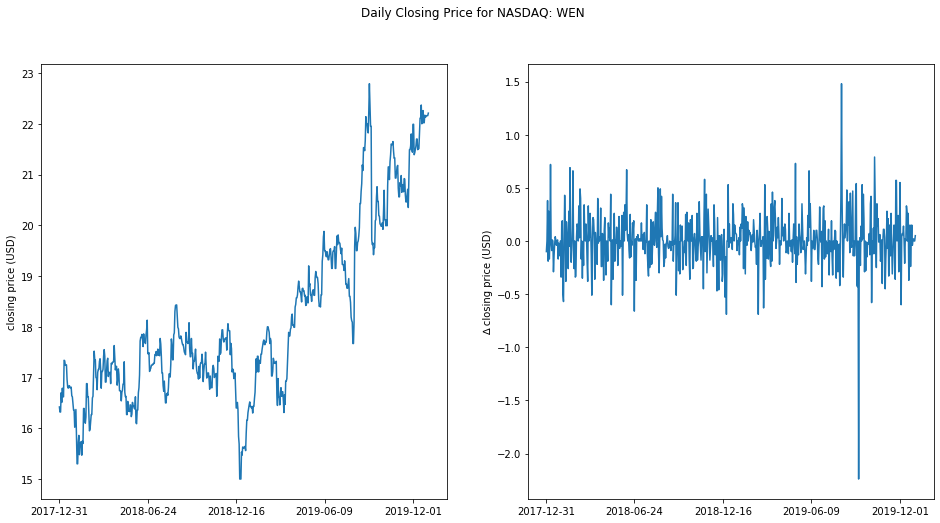

In [10]:
daily_close = data.groupby('day')['close/last'].mean()

fig, (ax1, ax2)= plt.subplots(1, 2, figsize=(16, 8))
fig.suptitle('Daily Closing Price for NASDAQ: WEN')
ax1.plot(daily_close.index, daily_close)
ax1.set_xticks(daily_close.index[::150])
ax1.set_ylabel('closing price (USD)')
ax2.plot(daily_close.index, daily_close.diff().round(2))
ax2.set_xticks(daily_close.index[::150])
ax2.set_ylabel('∆ closing price (USD)')
plt.savefig('prices.png');

In [4]:
def autocorrelation_plots(time_data, lags=20):
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    fig = sm.graphics.tsa.plot_acf(time_data, lags=lags, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(time_data, lags=lags, ax=ax[1])
    plt.show()

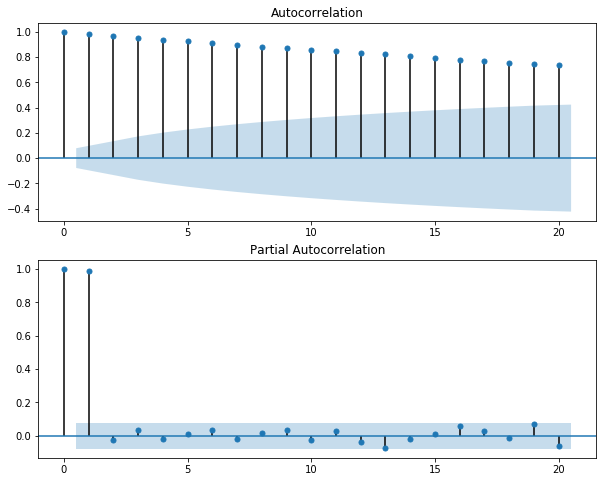

In [5]:
autocorrelation_plots(daily_close)

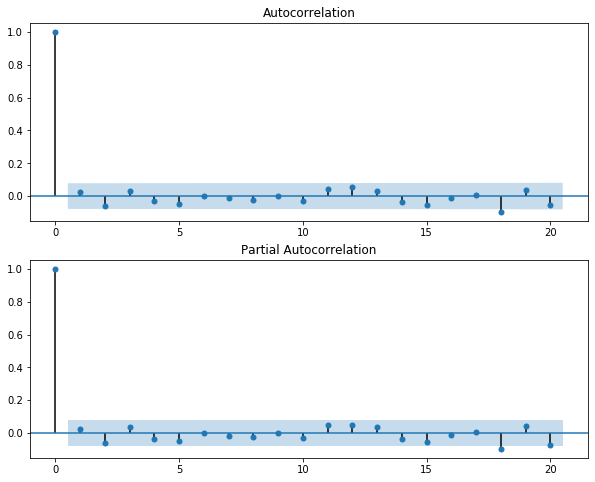

In [6]:
autocorrelation_plots(daily_close.diff().round(2).dropna())

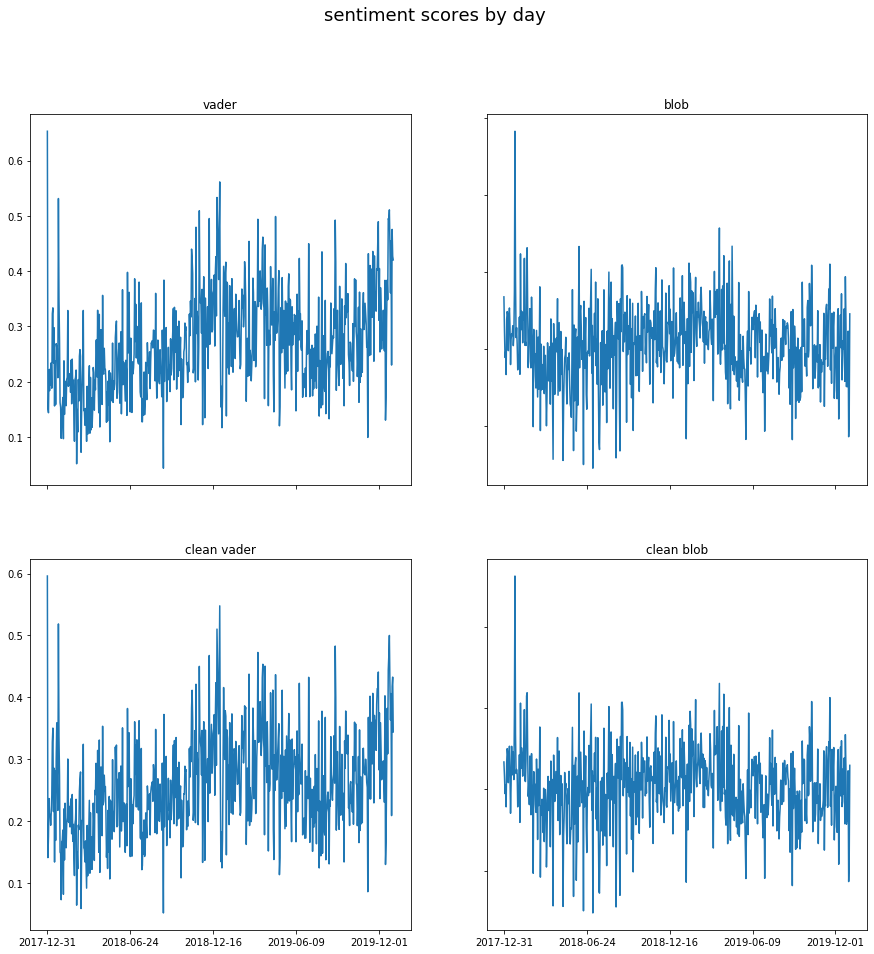

In [13]:
daily = data.groupby('day')[['vader_sentiment', 'blob_sentiment',
                        'clean_vader', 'clean_blob']].mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('sentiment scores by day', fontsize=18)
ax1.plot(daily.index, daily['vader_sentiment'])
ax1.set_title('vader')
ax1.set_xticks(daily_close.index[::150])
ax2.plot(daily.index, daily['blob_sentiment'])
ax2.set_xticks(daily_close.index[::150])
ax2.set_title('blob')
ax3.plot(daily.index, daily['clean_vader'])
ax3.set_xticks(daily_close.index[::150])
ax3.set_title('clean vader')
ax4.plot(daily.index, daily['clean_blob'])
ax4.set_xticks(daily_close.index[::150])
ax4.set_title('clean blob')

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig('sentiments.png')

vader_sentiment


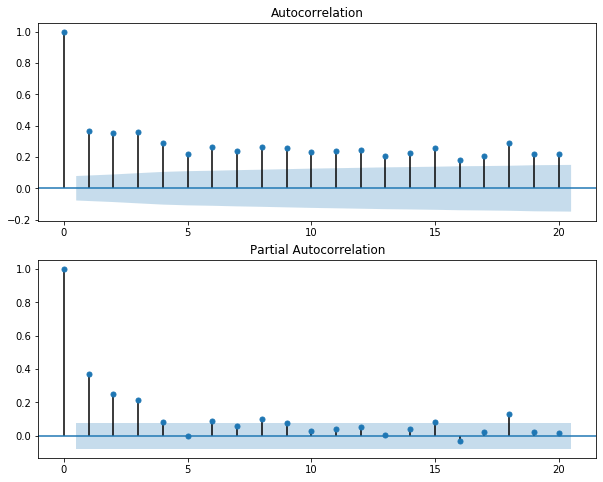


clean_vader


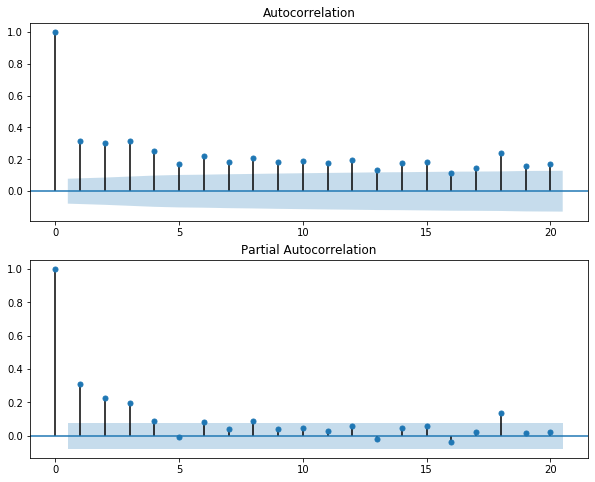


blob_sentiment


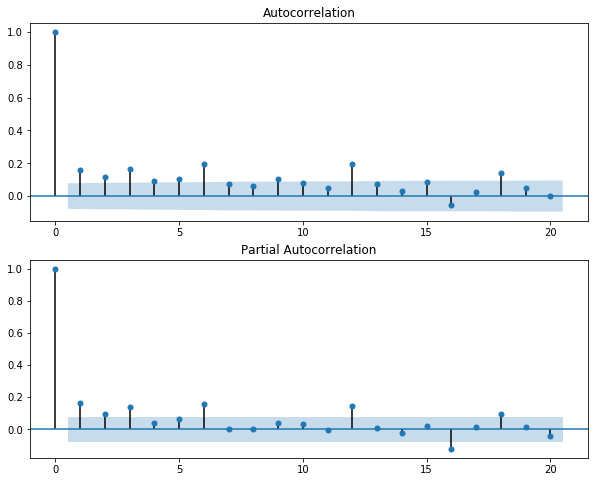


clean_blob


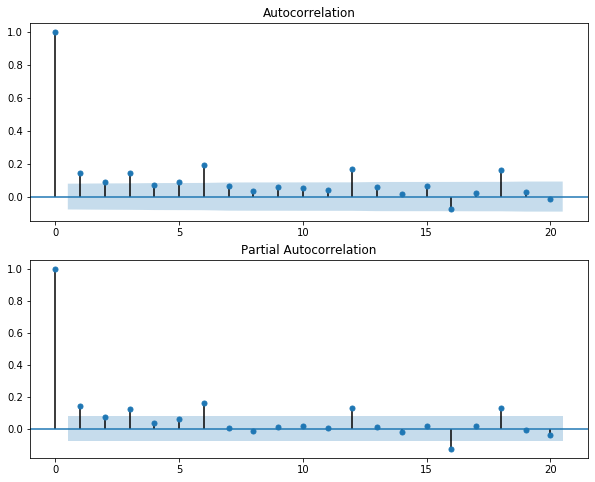

In [8]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily[col])
    print()

vader_sentiment


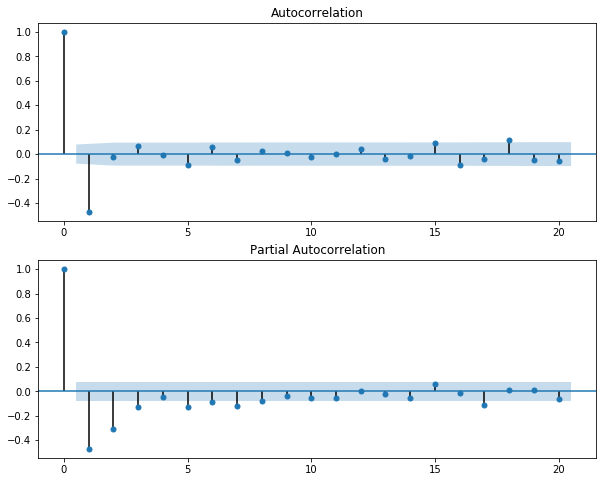


clean_vader


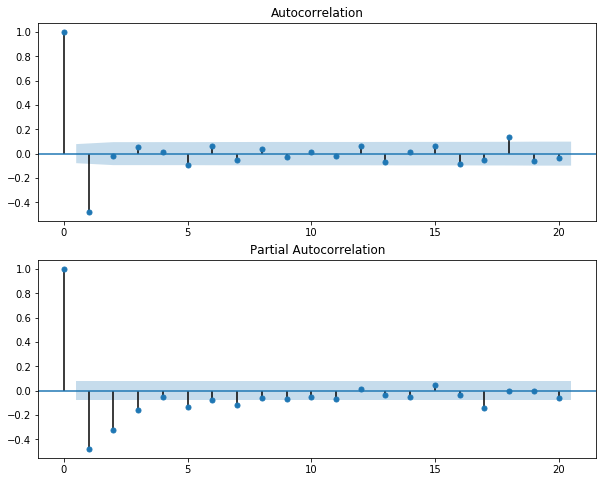


blob_sentiment


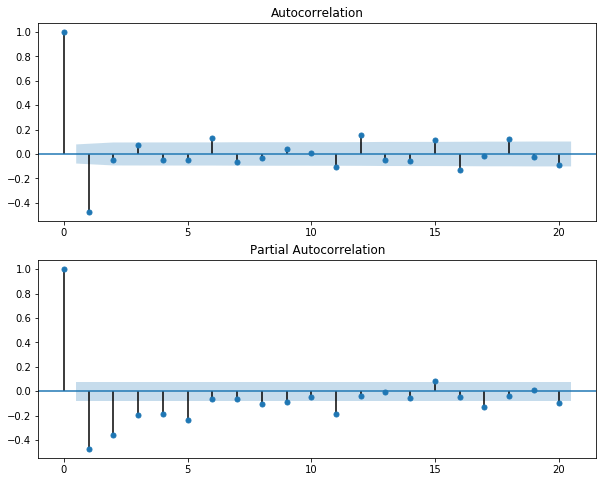


clean_blob


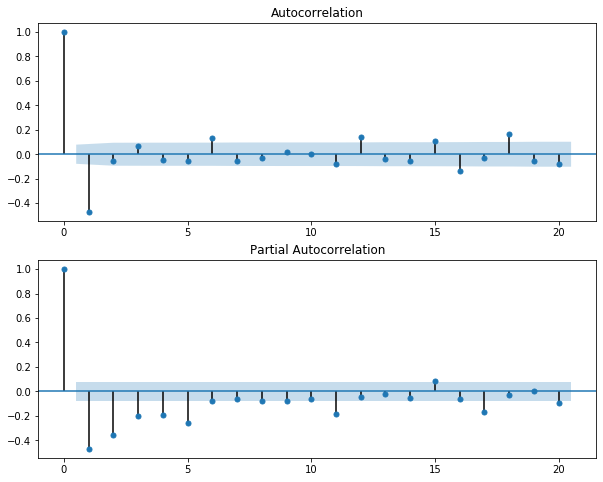

In [9]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily[col].diff().dropna())
    print()

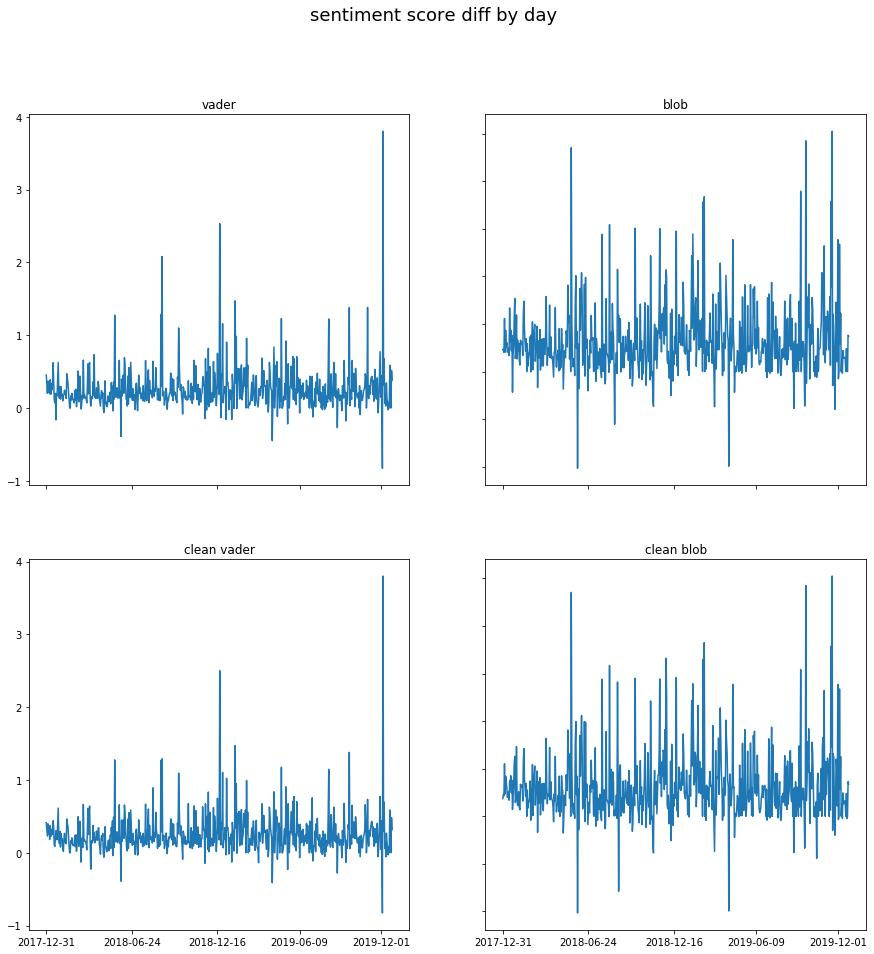

In [15]:
pop = data[data['retweets'] > 0]
pop['scale'] = [np.log(i+1) for i in pop['retweets']]
for col in ['vader_sentiment', 'blob_sentiment', 'clean_vader', 'clean_blob']:
    pop[col] = pop[col]*pop['scale']

daily_pop = pop.groupby('day')[
                        ['vader_sentiment', 'blob_sentiment',
                        'clean_vader', 'clean_blob']].mean()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle('sentiment score diff by day', fontsize=18)
ax1.plot(daily_pop.index, daily_pop['vader_sentiment'])
ax1.set_title('vader')
ax1.set_xticks(daily_close.index[::150])
ax2.plot(daily_pop.index, daily_pop['blob_sentiment'])
ax2.set_xticks(daily_close.index[::150])
ax2.set_title('blob')
ax3.plot(daily_pop.index, daily_pop['clean_vader'])
ax3.set_xticks(daily_close.index[::150])
ax3.set_title('clean vader')
ax4.plot(daily_pop.index, daily_pop['clean_blob'])
ax4.set_xticks(daily_close.index[::150])
ax4.set_title('clean blob')

for ax in fig.get_axes():
    ax.label_outer()

plt.savefig('sentiments_diff.png')

vader_sentiment


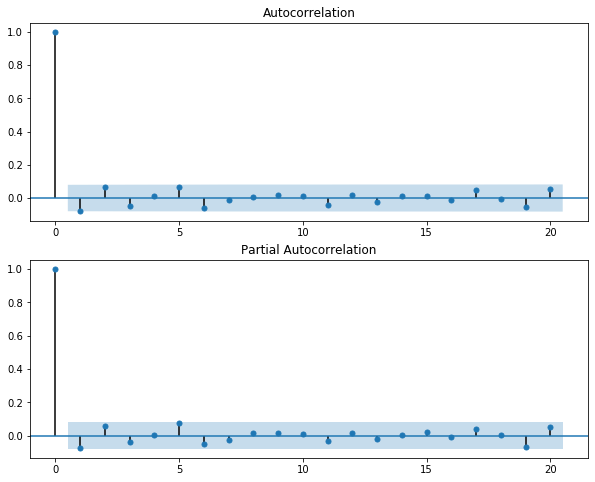


clean_vader


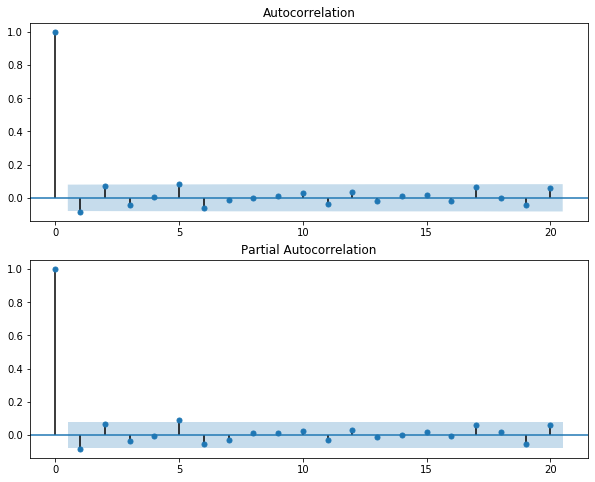


blob_sentiment


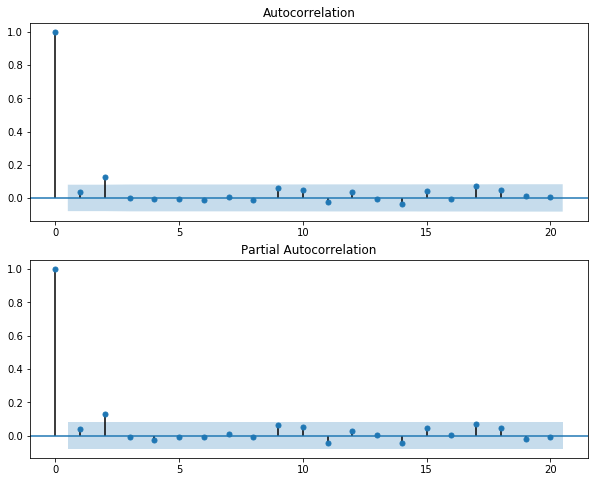


clean_blob


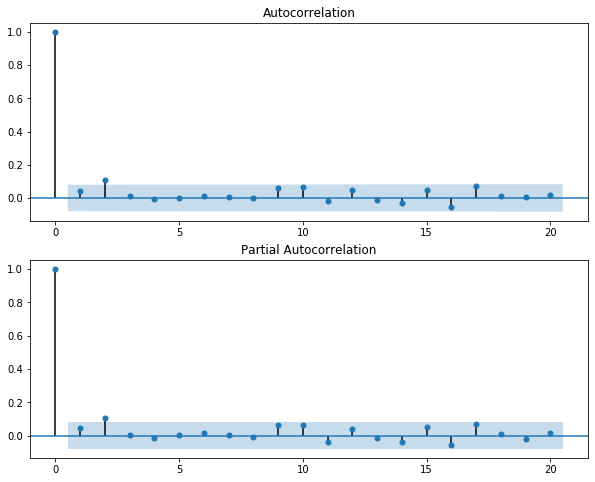

In [11]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily_pop[col])
    print()

vader_sentiment


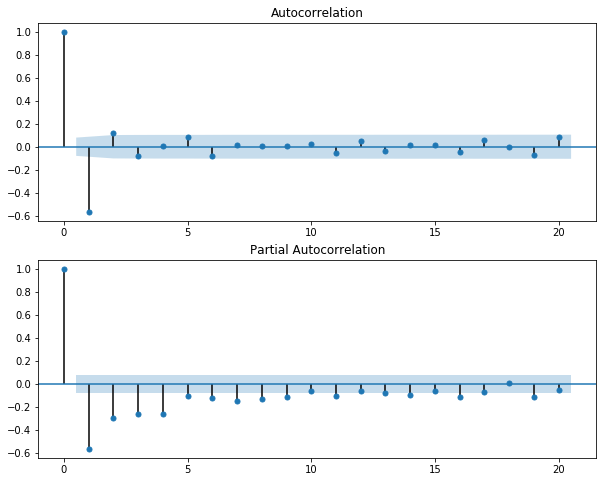


clean_vader


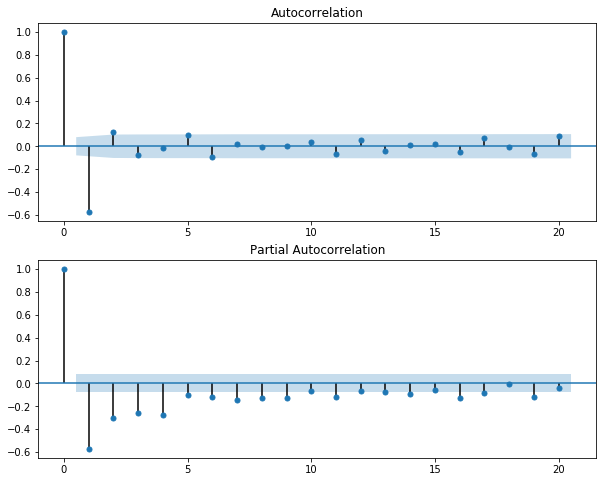


blob_sentiment


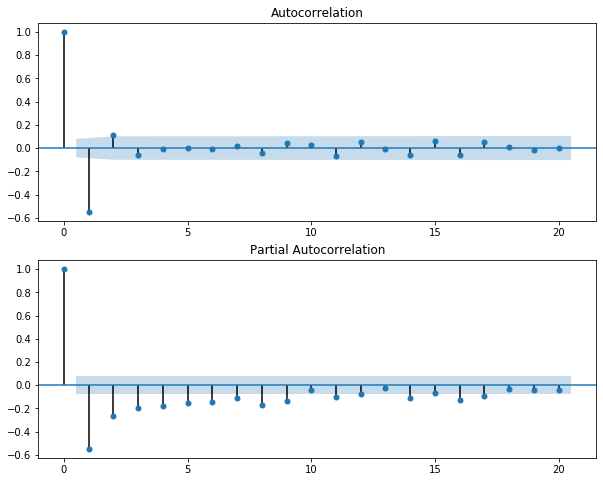


clean_blob


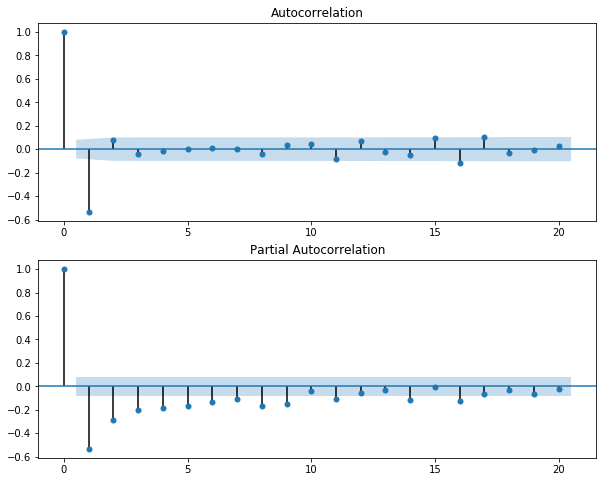

In [12]:
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    print(col)
    autocorrelation_plots(daily_pop[col].diff().dropna())
    print()

In [13]:
daily_close.shape[0]

627

In [30]:
y = daily_close.diff().loc[:'2019-10-31']

aic = []
i=1
df_type = ['all', 'favorited']
for col in ['vader_sentiment', 'clean_vader', 'blob_sentiment', 'clean_blob']:
    for idx, df in enumerate([daily, daily_pop]):
        for lags in range(1, 8):
            x = df[col].diff().loc[:'2019-10-31']
            train = pd.concat([y, x], axis=1)
            model = VARMAX(train, order=(lags, 0), trend='n')
            results = model.fit(maxiter=1000, disp=False)
            aic.append((f'{df_type[idx]} tweets, {col}, {lags} lags', results.aic))
            if i%7 == 0:
                print(f'{i} models run')
                print('...')
            i += 1
            
min(aic, key=lambda x: x[1])

7 models run
...
14 models run
...
21 models run
...
28 models run
...
35 models run
...
42 models run
...
49 models run
...
56 models run
...


('all tweets, clean_blob, 5 lags', -1809.3767624632465)

In [32]:
y = daily_close.diff()
x = daily['clean_blob'].diff()

model_data = pd.concat([y, x], axis=1).dropna()
train = model_data.loc[:'2019-10-31']
test = model_data.loc['2019-11-01':]

model = VARMAX(train, order=(5, 0), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['close/last', 'clean_blob']",No. Observations:,574
Model:,VAR(5),Log Likelihood,928.062
,+ intercept,AIC,-1806.125
Date:,"Tue, 28 Apr 2020",BIC,-1697.309
Time:,15:24:02,HQIC,-1763.681
Sample:,0,,
,- 574,,
Covariance Type:,opg,,
Ljung-Box (Q):,"49.49, 76.36",Jarque-Bera (JB):,"4371.34, 30.17"
Prob(Q):,"0.14, 0.00",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"1.68, 0.67",Skew:,"-0.80, -0.09"


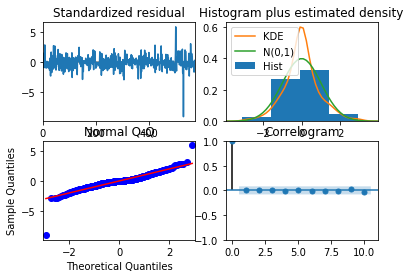

In [33]:
results.plot_diagnostics()
plt.show()

In [37]:
train.index

Index(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
       '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
       ...
       '2019-10-21', '2019-10-22', '2019-10-23', '2019-10-24', '2019-10-25',
       '2019-10-27', '2019-10-28', '2019-10-29', '2019-10-30', '2019-10-31'],
      dtype='object', name='day', length=574)

In [36]:
test.head()

,close/last,clean_blob
day,,
2019-11-01,-4.500000e-01,-0.010235
2019-11-03,-1.700000e-01,0.003982
2019-11-04,-3.552714e-15,0.006860
2019-11-05,2.800000e-01,0.009265
2019-11-06,-7.000000e-02,0.060747


In [48]:
n = test.shape[0]
forecast = results.get_forecast(n).summary_frame()
forecast.index = test.index
forecast.head()

close/last,mean,mean_se,mean_ci_lower,mean_ci_upper
day,,,,
2019-11-01,0.032893,0.246107,-0.449469,0.515255
2019-11-03,0.011543,0.246433,-0.471457,0.494544
2019-11-04,0.005467,0.246579,-0.477818,0.488753
2019-11-05,-0.004291,0.246934,-0.488273,0.479690
2019-11-06,0.008385,0.247060,-0.475844,0.492614


In [49]:
last = daily_close.loc[train.index[-1]]
pred = []
upper = []
lower = []
for idx, i in enumerate(forecast['mean']):
    last += i
    pred.append(last)
    upper.append(last + forecast['mean_ci_upper'][idx])
    lower.append(last - abs(forecast['mean_ci_lower'][idx]))
forecast['pred'] = pred
forecast['upper'] = upper
forecast['lower'] = lower

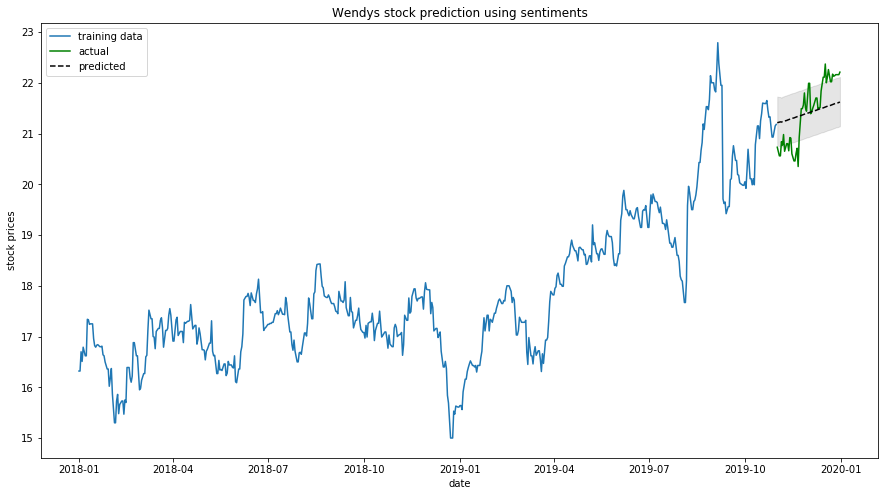

In [54]:
plt_data = pd.concat([daily_close.loc['2019-11-01':], forecast], axis=1)
x = pd.to_datetime(plt_data.index)

plt.figure(figsize=(15, 8))

plt.title('Wendys stock prediction using sentiments')
plt.ylabel('stock prices')
plt.xlabel('date')

plt.plot(pd.to_datetime(train.index), daily_close[train.index], label='training data')

plt.plot(x, plt_data['close/last'], 'g', label='actual')
plt.plot(x, plt_data['pred'], 'k--', label='predicted')
plt.fill_between(x, plt_data['lower'], plt_data['upper'], color='k', alpha=0.1)
plt.legend(loc=2);
plt.savefig('full_forecast.png')

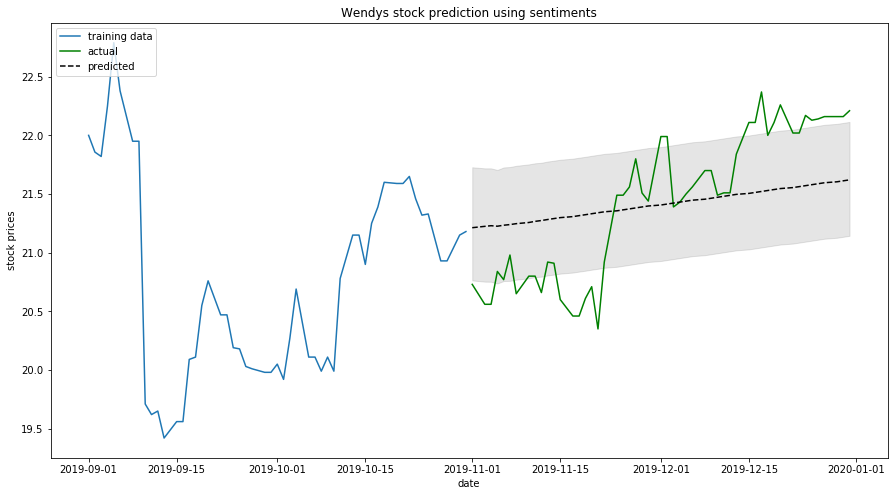

In [58]:
plt_data = pd.concat([daily_close.loc['2019-11-01':], forecast], axis=1)
x = pd.to_datetime(plt_data.index)

plt.figure(figsize=(15, 8))

plt.title('Wendys stock prediction using sentiments')
plt.ylabel('stock prices')
plt.xlabel('date')

trim = train.loc['2019-09-01':]
plt.plot(pd.to_datetime(trim.index), daily_close[trim.index], label='training data')

plt.plot(x, plt_data['close/last'], 'g', label='actual')
plt.plot(x, plt_data['pred'], 'k--', label='predicted')
plt.fill_between(x, plt_data['lower'], plt_data['upper'], color='k', alpha=0.1)
plt.legend(loc=2);
plt.savefig('trim_forecast.png')